In [1]:
# Required imports
import re
import string
import pandas as pd
import numpy as np
import nltk
import spacy
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, classification_report,
    roc_curve, auc # [1, 2]
)
from imblearn.over_sampling import SMOTE
import pickle

In [3]:
# Download necessary NLTK and spaCy resources (ensure these are run once)
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
!python -m spacy download en_core_web_sm


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ananya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ananya\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ananya\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     - -------------------------------------- 0.5/12.8 MB 3.3 MB/s eta 0:00:04
     -- ------------------------------------- 0.8/12.8 MB 2.1 MB/s eta 0:00:06
     --- ------------------------------------ 1.0/12.8 MB 1.8 MB/s eta 0:00:07
     ---- ----------------------------------- 1.3/12.8 MB 1.7 MB/s eta 0:00:07
     ---- ----------------------------------- 1.3/12.8 MB 1.7 MB/s eta 0:00:07
     ---- ----------------------------------- 1.6/12.8 MB 1.1 MB/s eta 0:00:10
     ---- ----------------------------------- 1.6/12.8 MB 1.1 MB/s eta 0:00:10
     ----- ---------------------------------- 1.8/12.8 MB 1.0 MB/s eta 0:00:11
     ------ --------------------------------- 2.1/12.8 MB 1.0 MB/s eta 0:00:11
     ------ --------------------------------- 2.1/12.8 MB 1.0 MB/s eta 0:00:11
     -------- ------------------------------- 2.6/12.8 MB 1.1 MB/s eta 0:00:10
     --------- ------------------------------ 2.9/12.8 MB 1


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
# Setup
stop_words = set(nltk.corpus.stopwords.words('english')) # [2]
lemmatizer = nltk.stem.WordNetLemmatizer() # [2]
nlp = spacy.load("en_core_web_sm") # [2]


In [5]:
# Cleaning functions
# The original clean_text function for basic cleaning (punctuation, numbers, spaces) [2, 3]
def clean_text(text):
    text = text.lower() # [3]
    text = re.sub(r"http\S+|@\w+|#\w+", "", text) # [2]
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text) # [3]
    text = re.sub(r"\d+", "", text) # [3]
    text = re.sub(r"\s+", " ", text) # [3]
    return text.strip() # [3]

In [6]:
# The spacy_preprocess function for more comprehensive cleaning (lemmatization, stop words) [3]
def spacy_preprocess(text):
    text = re.sub(r"http\S+|www\S+|@\w+|#\w+", "", text) # [3]
    doc = nlp(text.lower()) # [3]
    return " ".join([token.lemma_ for token in doc if token.is_alpha and not token.is_stop]) # [3]
# Load dataset
columns = [
    'tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
    'negativereason', 'negativereason_confidence', 'airline',
    'airline_sentiment_gold', 'name', 'negativereason_gold',
    'retweet_count', 'text', 'tweet_coord', 'tweet_created',
    'tweet_location', 'user_timezone' # [3, 4]
]
# Original approach for loading and immediate column selection/renaming [4]
# This handles the potential ambiguity: assuming 'sentiment_analysis.csv' has a header row that matches
# the initial 'columns' list, and then we select and rename.
df = pd.read_csv('../data/sentiment_analysis.csv', names=columns, header=0) # [4]
df = df[['airline_sentiment','airline', 'text']] # [4]
df.columns = ['label','airline', 'text'] # [4]
df.dropna(subset=['label', 'text'], inplace=True) # [4]

In [7]:
# Preprocess
# Applying the comprehensive spacy_preprocess for better feature representation [4]
df['clean_text'] = df['text'].apply(spacy_preprocess) # [4]

# Split data
# **CORRECTION 1: Ensure consistent preprocessing.**
# We use the 'clean_text' column (processed with spacy_preprocess) for feature extraction.
# This means X_train and X_test will already be lemmatized and have stop words removed.
X = df['clean_text'] # Use the spacy-preprocessed text
y = df['label'] # [4]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42 # [4]
)

# Vectorize
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_df=0.9, min_df=5) # [5]
X_train_vec = vectorizer.fit_transform(X_train) # [5]
X_test_vec = vectorizer.transform(X_test) # [5]

# Balance data using SMOTE
sm = SMOTE(random_state=42) # [5]
X_res, y_res = sm.fit_resample(X_train_vec, y_train) # [5]

# Train Model
model = LogisticRegression(max_iter=1000) # Added max_iter to prevent convergence warnings for larger datasets
model.fit(X_res, y_res) # [5]

# Predict
y_pred = model.predict(X_test_vec) # [5]

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred)) # [5, 6]
print("Precision:", precision_score(y_test, y_pred, average='weighted')) # [6]
print("Recall:", recall_score(y_test, y_pred, average='weighted')) # [6]
print("F1 Score:", f1_score(y_test, y_pred, average='weighted')) # [6]
print("\nClassification Report:\n", classification_report(y_test, y_pred)) # [6]

# Misclassified analysis (no changes needed here) [6, 7]
misclassified = pd.DataFrame({
    'Original Text': df.loc[y_test.index, 'text'], # Get original text using the test set's index
    'Cleaned Text': X_test, # This now contains the spacy_preprocessed text
    'True Label': y_test,
    'Predicted Label': y_pred
})
misclassified = misclassified[misclassified['True Label'] != misclassified['Predicted Label']] # [6, 7]
print("\nMisclassified Examples (first 10):\n", misclassified.head(10)) # [7]


Accuracy: 0.7715163934426229
Precision: 0.7842201324189767
Recall: 0.7715163934426229
F1 Score: 0.7764998453704555

Classification Report:
               precision    recall  f1-score   support

    negative       0.89      0.83      0.86      1889
     neutral       0.55      0.62      0.58       580
    positive       0.64      0.72      0.68       459

    accuracy                           0.77      2928
   macro avg       0.69      0.72      0.71      2928
weighted avg       0.78      0.77      0.78      2928


Misclassified Examples (first 10):
                                            Original Text  \
927    @united still waiting to hear back. My wallet ...   
12542  @AmericanAir and btwn gate a8 &amp; a15 I lost...   
9595   @USAirways : When You've Got to Get There, We'...   
2366   @united No wonder the cabin is filthy. #badser...   
914           @united So you are inadequate by accident?   
7698   @JetBlue can we get a honest update on departu...   
14593  @AmericanAir ah

In [8]:
# Top Features Analysis
# **CORRECTION 2: Correctly interpret multiclass coefficients.**
# For multiclass Logistic Regression, model.coef_ has shape (n_classes, n_features).
# Each row corresponds to a class. We need to identify which class each row represents.
class_labels = model.classes_ # Get the order of classes as seen by the model

print("\n--- Top Features per Class ---")
feature_names = vectorizer.get_feature_names_out() # [7]

# Iterate through each class to find its top positive and negative features
for i, class_label in enumerate(class_labels):
    coefficients = model.coef_[i] # Coefficients for the current class [7]
    top_pos_indices = np.argsort(coefficients)[-10:] # Top 10 features with highest positive coefficients for this class [7]
    top_neg_indices = np.argsort(coefficients)[:10] # Top 10 features with highest negative coefficients for this class [7]

    print(f"\nTop features for '{class_label}' class:")
    print(f"  Most Contributing to '{class_label}': {[feature_names[idx] for idx in top_pos_indices]}")
    print(f"  Least Contributing to '{class_label}' (or most against): {[feature_names[idx] for idx in top_neg_indices]}")



--- Top Features per Class ---

Top features for 'negative' class:
  Most Contributing to 'negative': ['suck', 'customer', 'miss', 'luggage', 'lose', 'bag', 'delay', 'hold', 'bad', 'hour']
  Least Contributing to 'negative' (or most against): ['thank', 'awesome', 'love', 'kudo', 'amazing', 'good airline', 'wonderful', 'take care', 'hold plane', 'great']

Top features for 'neutral' class:
  Most Contributing to 'neutral': ['australia', 'dm', 'hawaii', 'winner', 'photo', 'mexico', 'journal', 'carry', 'delay cancel', 'hi']
  Least Contributing to 'neutral' (or most against): ['helpful', 'awesome', 'fix', 'hour', 'great', 'airline', 'customer', 'amazing', 'experience', 'agent']

Top features for 'positive' class:
  Most Contributing to 'positive': ['appreciate', 'good', 'love', 'wonderful', 'excellent', 'thank help', 'thank', 'amazing', 'great', 'awesome']
  Least Contributing to 'positive' (or most against): ['need', 'flight', 'pay', 'hour', 'online', 'hold', 'happen', 'leave', 'delay', 

In [9]:
# ROC Curve
# **CORRECTION 3: Use the consistently trained model for ROC curve, or train OneVsRestClassifier on balanced data.**
# We will train the OneVsRestClassifier on the SMOTE-balanced training data (X_res, y_res)
# for consistency with the main model's training approach.
y_test_bin = label_binarize(y_test, classes=["negative", "neutral", "positive"]) # [7]
# y_train_bin is not directly needed for training the classifier if we use y_res, but for consistency in binarization:
y_res_bin = label_binarize(y_res, classes=["negative", "neutral", "positive"])

n_classes = y_test_bin.shape[1] # [8]

# Train the OneVsRestClassifier on the SMOTE-balanced data
classifier = OneVsRestClassifier(LogisticRegression(max_iter=1000)) # [8]
classifier.fit(X_res, y_res_bin) # **Trained on SMOTE-balanced data (X_res, y_res_bin)**

y_score = classifier.predict_proba(X_test_vec) # [8]

fpr, tpr, roc_auc = {}, {}, {} # [8]
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i]) # [8]
    roc_auc[i] = auc(fpr[i], tpr[i]) # [8]

plt.figure(figsize=(8,6)) # [8]
colors = ['blue', 'orange', 'green'] # [8]
class_names = ['negative', 'neutral', 'positive'] # [8]

<Figure size 800x600 with 0 Axes>

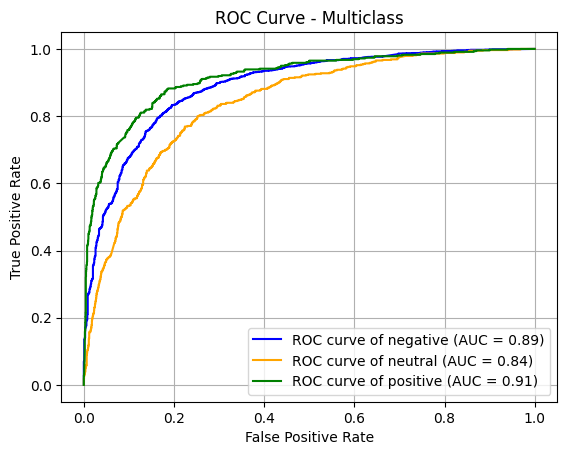

In [10]:
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], label=f'ROC curve of {class_names[i]} (AUC = {roc_auc[i]:0.2f})') # [8]

plt.plot([0,1], [0,1], 'k--') # [9]
plt.xlabel('False Positive Rate') # [9]
plt.ylabel('True Positive Rate') # [9]
plt.title('ROC Curve - Multiclass') # [9]
plt.legend(loc="lower right") # [9]
plt.grid() # [9]
plt.show() # [9]

# Save model/vectorizer (no changes needed here) [9]
with open("model.pkl", "wb") as f:
    pickle.dump(model, f)
with open("vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)
